DATA CLEANING & VISUALIZATION

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

data_path = "data/"
csv_files = glob(os.path.join(data_path, "*_matchlogs.csv"))
print(f"Found {len(csv_files)} CSV files.")

Found 27 CSV files.


In [3]:
def clean_matchlog(df):
    """
    Cleans and standardizes FBRef match log data for ML use.
    Uses existing 'Result' column, adds goal/xG diffs, and ensures numeric types.
    """
    # Columns that matter
    useful_cols = [
        'Date', 'Comp', 'Venue', 'Result', 'GF', 'GA', 'xG', 'xGA', 'Poss',
        'Opponent', 'Team', 'Season'
    ]
    
    df = df[[c for c in useful_cols if c in df.columns]].copy()

    # Convert numerics safely
    for col in ['GF', 'GA', 'xG', 'xGA', 'Poss']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Compute derived metrics
    df['GoalDiff'] = df['GF'] - df['GA']
    df['xGDiff'] = df['xG'] - df['xGA']

    # Normalize results (FBRef uses 'W', 'D', 'L')
    df['Outcome'] = df['Result'].map({'W': 'Win', 'D': 'Draw', 'L': 'Loss'})

    # Parse dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows missing critical info
    df = df.dropna(subset=['Date', 'Outcome'])
    drop_cols = ['Result']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    return df


In [4]:
all_dfs = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        team_name = os.path.basename(file).split("_")[0]
        print(f"🧹 Cleaning {team_name} ({len(df)} rows)...")
        clean_df = clean_matchlog(df)
        all_dfs.append(clean_df)
    except Exception as e:
        print(f"⚠️ Error cleaning {file}: {e}")

combined = pd.concat(all_dfs, ignore_index=True)
print(f"\n✅ Combined dataset: {len(combined)} matches across {len(all_dfs)} teams.")
combined.to_csv(os.path.join(data_path, "all_teams_cleaned.csv"), index=False)


🧹 Cleaning arsenal (110 rows)...
🧹 Cleaning atalanta (108 rows)...
🧹 Cleaning athletic-club-bilbao (101 rows)...
🧹 Cleaning atletico-madrid (109 rows)...
🧹 Cleaning barcelona (113 rows)...
🧹 Cleaning bayer-leverkusen (103 rows)...
🧹 Cleaning bayern-munich (100 rows)...
🧹 Cleaning borussia-dortmund (100 rows)...
🧹 Cleaning chelsea (108 rows)...
🧹 Cleaning eintracht-frankfurt (96 rows)...
🧹 Cleaning getafe (85 rows)...
🧹 Cleaning inter-milan (108 rows)...
🧹 Cleaning juventus (94 rows)...
🧹 Cleaning liverpool (114 rows)...
🧹 Cleaning manchester-city (114 rows)...
🧹 Cleaning marseille (88 rows)...
🧹 Cleaning napoli (90 rows)...
🧹 Cleaning newcastle-united (99 rows)...
🧹 Cleaning osasuna (86 rows)...
🧹 Cleaning psg (111 rows)...
🧹 Cleaning qarabag-fk (32 rows)...
🧹 Cleaning real-betis (85 rows)...
🧹 Cleaning real-madrid (116 rows)...
🧹 Cleaning real-sociedad (88 rows)...
🧹 Cleaning sevilla (91 rows)...
🧹 Cleaning tottenham-hotspur (101 rows)...
🧹 Cleaning villarreal (89 rows)...

✅ Combined

In [5]:
combined.head()

,Date,Comp,Venue,GF,GA,xG,xGA,Poss,Opponent,Team,Season,GoalDiff,xGDiff,Outcome
0,2023-08-06,Community Shield,Neutral,NaN,NaN,NaN,NaN,45.0,Manchester City,Arsenal,2023-2024,NaN,NaN,Draw
1,2023-08-12,Premier League,Home,2.0,1.0,0.8,1.2,78.0,Nott'ham Forest,Arsenal,2023-2024,1.0,-0.4,Win
2,2023-08-21,Premier League,Away,1.0,0.0,2.0,1.0,53.0,Crystal Palace,Arsenal,2023-2024,1.0,1.0,Win
3,2023-08-26,Premier League,Home,2.0,2.0,3.2,0.6,71.0,Fulham,Arsenal,2023-2024,0.0,2.6,Draw
4,2023-09-03,Premier League,Home,3.0,1.0,2.3,0.9,55.0,Manchester Utd,Arsenal,2023-2024,2.0,1.4,Win


In [6]:
# Check if NAn in GF GA xG xGA are only when draw.
nan_checks = combined[combined[['GF', 'GA', 'xG', 'xGA']].isna().any(axis=1)]
print(f"Rows with NaNs in GF, GA, xG, or xGA:\n{nan_checks}")

Rows with NaNs in GF, GA, xG, or xGA:
           Date              Comp    Venue   GF   GA   xG  xGA  Poss  \
0    2023-08-06  Community Shield  Neutral  NaN  NaN  NaN  NaN  45.0   
8    2023-09-27           EFL Cup     Away  1.0  0.0  NaN  NaN  60.0   
15   2023-11-01           EFL Cup     Away  1.0  3.0  NaN  NaN  72.0   
29   2024-01-07            FA Cup     Home  0.0  2.0  NaN  NaN  54.0   
39   2024-03-12      Champions Lg     Home  NaN  NaN  0.9  0.5  58.0   
...         ...               ...      ...  ...  ...  ...  ...   ...   
2563 2023-11-02      Copa del Rey     Away  5.0  0.0  NaN  NaN  76.0   
2567 2023-11-22      Copa del Rey     Away  2.0  1.0  NaN  NaN  70.0   
2577 2024-01-08      Copa del Rey     Away  NaN  NaN  NaN  NaN  57.0   
2610 2024-10-29      Copa del Rey     Away  6.0  1.0  NaN  NaN   NaN   
2614 2024-12-04      Copa del Rey     Away  0.0  1.0  NaN  NaN  27.0   

             Opponent        Team     Season  GoalDiff  xGDiff Outcome  
0     Manchester City   

In [7]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639 entries, 0 to 2638
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2639 non-null   datetime64[ns]
 1   Comp      2639 non-null   object        
 2   Venue     2639 non-null   object        
 3   GF        2602 non-null   float64       
 4   GA        2602 non-null   float64       
 5   xG        2346 non-null   float64       
 6   xGA       2346 non-null   float64       
 7   Poss      2610 non-null   float64       
 8   Opponent  2639 non-null   object        
 9   Team      2639 non-null   object        
 10  Season    2639 non-null   object        
 11  GoalDiff  2602 non-null   float64       
 12  xGDiff    2346 non-null   float64       
 13  Outcome   2639 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(6)
memory usage: 288.8+ KB


In [8]:
ml_data = combined.dropna(subset=['GF', 'GA', 'xG', 'xGA', "Poss", "Date", ])
print(f"\n✅ ML dataset: {len(ml_data)} matches after dropping NaNs in GF, GA, xG, xGA.")
ml_data.to_csv(os.path.join(data_path, "all_teams_ml_ready.csv"), index=False)


✅ ML dataset: 2336 matches after dropping NaNs in GF, GA, xG, xGA.


In [9]:
# check for remaning NaNs
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2336 entries, 1 to 2638
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2336 non-null   datetime64[ns]
 1   Comp      2336 non-null   object        
 2   Venue     2336 non-null   object        
 3   GF        2336 non-null   float64       
 4   GA        2336 non-null   float64       
 5   xG        2336 non-null   float64       
 6   xGA       2336 non-null   float64       
 7   Poss      2336 non-null   float64       
 8   Opponent  2336 non-null   object        
 9   Team      2336 non-null   object        
 10  Season    2336 non-null   object        
 11  GoalDiff  2336 non-null   float64       
 12  xGDiff    2336 non-null   float64       
 13  Outcome   2336 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(6)
memory usage: 273.8+ KB


C:\Users\jalil\AppData\Local\Temp\ipykernel_20368\3240097859.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ml_data, x='Outcome', order=['Win', 'Draw', 'Loss'], palette='viridis')


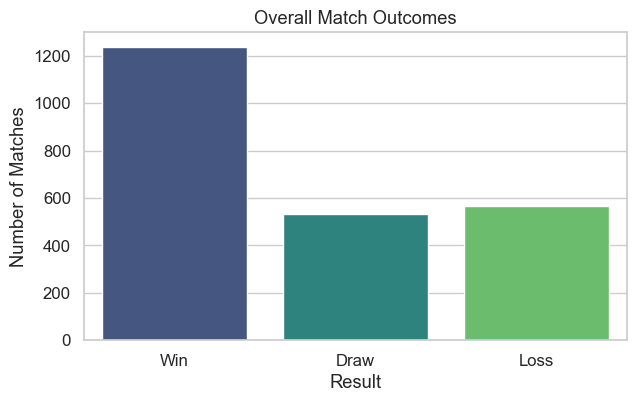

In [13]:
plt.figure(figsize=(7,4))
sns.countplot(data=ml_data, x='Outcome', order=['Win', 'Draw', 'Loss'], palette='viridis')
plt.title('Overall Match Outcomes')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.show()


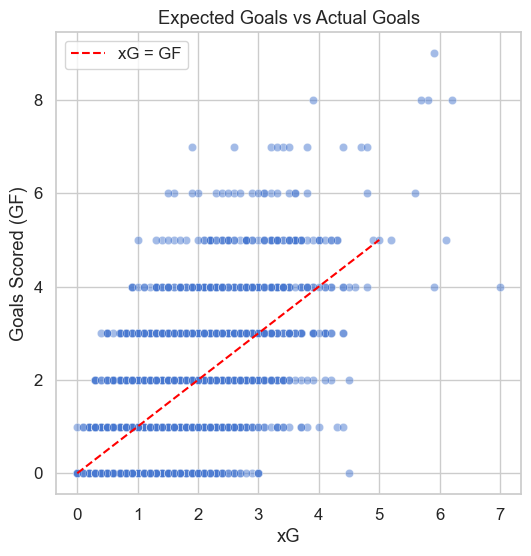

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=ml_data, x='xG', y='GF', alpha=0.5)
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='xG = GF')
plt.title('Expected Goals vs Actual Goals')
plt.xlabel('xG')
plt.ylabel('Goals Scored (GF)')
plt.legend()
plt.show()

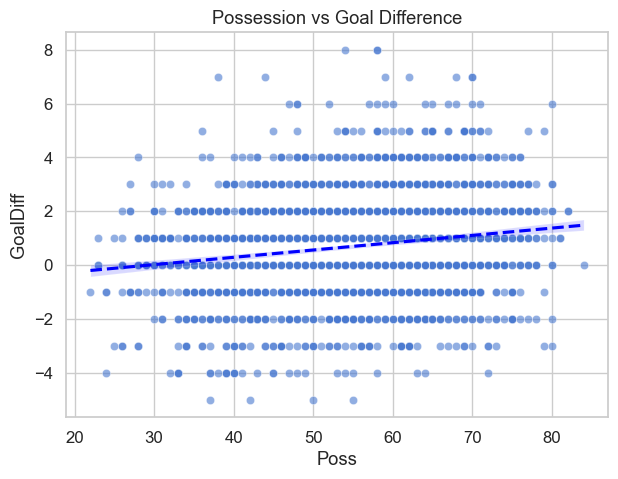

In [15]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=ml_data, x='Poss', y='GoalDiff', alpha=0.6)
plt.title('Possession vs Goal Difference')
plt.xlabel('Possession (%)')
plt.ylabel('Goal Difference')
#plot correlation regression line
sns.regplot(data=ml_data, x='Poss', y='GoalDiff', scatter=False, color='blue', line_kws={"linestyle":"--"})
plt.show()


C:\Users\jalil\AppData\Local\Temp\ipykernel_20368\3638849063.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=team_summary.index, y=team_summary['GoalDiff'], palette='coolwarm')


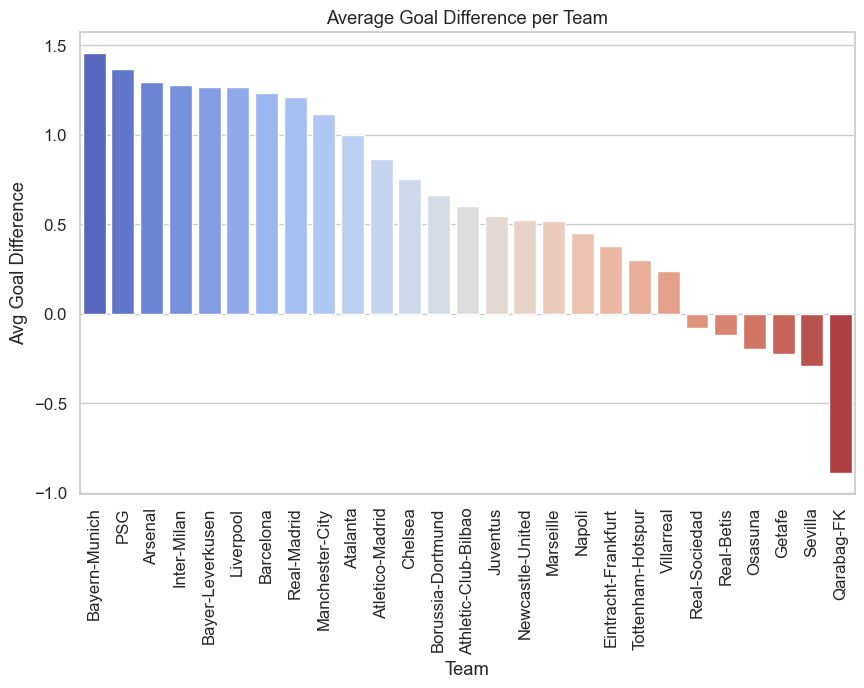

In [16]:
team_summary = (
    ml_data.groupby('Team')[['GF','GA','xG','xGA','GoalDiff','xGDiff']]
    .mean()
    .sort_values('GoalDiff', ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(x=team_summary.index, y=team_summary['GoalDiff'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Average Goal Difference per Team')
plt.xlabel('Team')
plt.ylabel('Avg Goal Difference')
plt.show()


In [17]:
#show how many remaining for each club
print("\nNumber of matches per team in ML dataset:")
team_counts = ml_data['Team'].value_counts()
print(team_counts)


Number of matches per team in ML dataset:
Team
Real-Madrid             101
Barcelona               100
Arsenal                  99
Atalanta                 99
Inter-Milan              98
PSG                      96
Manchester-City          95
Liverpool                95
Borussia-Dortmund        95
Bayern-Munich            94
Atletico-Madrid          94
Tottenham-Hotspur        91
Bayer-Leverkusen         91
Athletic-Club-Bilbao     90
Chelsea                  89
Eintracht-Frankfurt      88
Juventus                 86
Villarreal               84
Napoli                   84
Sevilla                  82
Newcastle-United         82
Marseille                81
Osasuna                  76
Real-Betis               76
Real-Sociedad            76
Getafe                   76
Qarabag-FK               18
Name: count, dtype: int64


In [18]:
#print qarabag matches
qa = ml_data[ml_data['Team'] == 'Qarabag-FK']
qa.head()

,Date,Comp,Venue,GF,GA,xG,xGA,Poss,Opponent,Team,Season,GoalDiff,xGDiff,Outcome
2045,2023-09-21,Europa Lg,Home,1.0,0.0,1.8,0.2,62.0,no Molde,Qarabag-FK,2023-2024,1.0,1.6,Win
2046,2023-10-05,Europa Lg,Away,1.0,0.0,0.9,0.8,52.0,se Häcken,Qarabag-FK,2023-2024,1.0,0.1,Win
2047,2023-10-26,Europa Lg,Away,1.0,5.0,0.9,2.5,39.0,de Leverkusen,Qarabag-FK,2023-2024,-4.0,-1.6,Loss
2048,2023-11-09,Europa Lg,Home,0.0,1.0,0.9,1.7,38.0,de Leverkusen,Qarabag-FK,2023-2024,-1.0,-0.8,Loss
2049,2023-11-30,Europa Lg,Away,2.0,2.0,1.4,2.9,42.0,no Molde,Qarabag-FK,2023-2024,0.0,-1.5,Draw


In [19]:
#print last 5 matches of qarabag and atletic club
ac = ml_data[ml_data['Team'] == 'Athletic Club']
print("\nLast 5 matches of Qarabag-FK:")
print(qa.tail())

print("\nLast 5 matches of Athletic Club:")
print(ac.tail())


Last 5 matches of Qarabag-FK:
           Date       Comp Venue   GF   GA   xG  xGA  Poss       Opponent  \
2064 2024-11-07  Europa Lg  Away  2.0  1.0  0.7  2.7  45.0  no Bodø/Glimt   
2065 2024-11-28  Europa Lg  Home  1.0  4.0  2.5  2.3  56.0        fr Lyon   
2066 2024-12-12  Europa Lg  Away  0.0  1.0  1.0  1.5  69.0    se Elfsborg   
2067 2025-01-23  Europa Lg  Home  2.0  3.0  1.4  0.7  63.0        ro FCSB   
2068 2025-01-30  Europa Lg  Away  0.0  3.0  0.2  3.7  55.0  gr Olympiacos   

            Team     Season  GoalDiff  xGDiff Outcome  
2064  Qarabag-FK  2024-2025       1.0    -2.0     Win  
2065  Qarabag-FK  2024-2025      -3.0     0.2    Loss  
2066  Qarabag-FK  2024-2025      -1.0    -0.5    Loss  
2067  Qarabag-FK  2024-2025      -1.0     0.7    Loss  
2068  Qarabag-FK  2024-2025      -3.0    -3.5    Loss  

Last 5 matches of Athletic Club:
Empty DataFrame
Columns: [Date, Comp, Venue, GF, GA, xG, xGA, Poss, Opponent, Team, Season, GoalDiff, xGDiff, Outcome]
Index: []


In [20]:
#add is_Home
ml_data['is_Home'] = ml_data['Venue'].apply(lambda x: 1 if x == 'Home' else 0)


C:\Users\jalil\AppData\Local\Temp\ipykernel_20368\2471279196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['is_Home'] = ml_data['Venue'].apply(lambda x: 1 if x == 'Home' else 0)


Training MODELS

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

features = ['xG', 'xGA', 'xGDiff', 'Poss', 'is_Home']
target = 'Outcome'

le = LabelEncoder()
y = le.fit_transform(ml_data[target])
X = ml_data[features].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [25]:
from xgboost import XGBClassifier

xgb_model1 = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model1.fit(X_train, y_train)

print("✅ Model trained.")
print("Validation Accuracy:", round(xgb_model1.score(X_val, y_val), 3))

✅ Model trained.
Validation Accuracy: 0.579


In [23]:
df_match = pd.read_csv("data/qarabag_bilbao_2025_2026.csv")

print("✅ Loaded:", df_match.shape, "rows")
df_match.head()

✅ Loaded: (133, 15) rows


,Date,Comp,Venue,Result,GF,GA,xG,xGA,Poss,Opponent,Team,Season,GoalDiff,xGDiff,Outcome
0,2023-07-11,Champions Lg,Away,W,2.0,1.0,NaN,NaN,NaN,gi Red Imps,Qarabag-FK,2023-2024,1.0,NaN,Win
1,2023-07-19,Champions Lg,Home,W,4.0,0.0,NaN,NaN,NaN,gi Red Imps,Qarabag-FK,2023-2024,4.0,NaN,Win
2,2023-07-26,Champions Lg,Away,L,2.0,3.0,NaN,NaN,NaN,pl Raków,Qarabag-FK,2023-2024,-1.0,NaN,Loss
3,2023-08-02,Champions Lg,Home,D,1.0,1.0,NaN,NaN,NaN,pl Raków,Qarabag-FK,2023-2024,0.0,NaN,Draw
4,2023-08-10,Europa Lg,Home,W,2.0,1.0,NaN,NaN,67.0,fi HJK,Qarabag-FK,2023-2024,1.0,NaN,Win


In [22]:
df_match['is_Home'] = (df_match['Venue'] == 'Home').astype(int)
df_match.head()

,Date,Comp,Venue,Result,GF,GA,xG,xGA,Poss,Opponent,Team,Season,GoalDiff,xGDiff,Outcome,is_Home
0,2023-07-11,Champions Lg,Away,W,2.0,1.0,NaN,NaN,NaN,gi Red Imps,Qarabag-FK,2023-2024,1.0,NaN,Win,0
1,2023-07-19,Champions Lg,Home,W,4.0,0.0,NaN,NaN,NaN,gi Red Imps,Qarabag-FK,2023-2024,4.0,NaN,Win,1
2,2023-07-26,Champions Lg,Away,L,2.0,3.0,NaN,NaN,NaN,pl Raków,Qarabag-FK,2023-2024,-1.0,NaN,Loss,0
3,2023-08-02,Champions Lg,Home,D,1.0,1.0,NaN,NaN,NaN,pl Raków,Qarabag-FK,2023-2024,0.0,NaN,Draw,1
4,2023-08-10,Europa Lg,Home,W,2.0,1.0,NaN,NaN,67.0,fi HJK,Qarabag-FK,2023-2024,1.0,NaN,Win,1


In [28]:
qarabag_2526 = df_match[df_match['Team'].str.contains('Qarabag', case=False)]
bilbao_2526  = df_match[df_match['Team'].str.contains('Athletic', case=False)]

qarabag_stats = qarabag_2526[['xG','xGA','xGDiff','Poss']].mean()
bilbao_stats  = bilbao_2526[['xG','xGA','xGDiff','Poss']].mean()

print("Qarabag averages:\n", qarabag_stats.round(2))
print("\nBilbao averages:\n", bilbao_stats.round(2))

Qarabag averages:
 xG         1.22
xGA        1.94
xGDiff    -0.72
Poss      49.64
dtype: float64

Bilbao averages:
 xG         1.40
xGA        1.04
xGDiff     0.36
Poss      50.25
dtype: float64


In [29]:
bilbao_home = pd.DataFrame([{
    'xG': bilbao_stats['xG'],
    'xGA': qarabag_stats['xGA'],
    'xGDiff': bilbao_stats['xG'] - qarabag_stats['xGA'],
    'Poss': (qarabag_stats['Poss'] + bilbao_stats['Poss']) / 2,
    'is_Home': 0
}])

In [30]:
bilbao_pred  = le.inverse_transform(xgb_model1.predict(bilbao_home))[0]

print(f"🚗 Athletic Club (Home) vs Qarabag → {bilbao_pred}")

🚗 Athletic Club (Home) vs Qarabag → Win


In [32]:
import numpy as np
bilbao_probs  = xgb_model1.predict_proba(bilbao_home)[0]

print("🚗 Athletic Club Home Probabilities:", dict(zip(le.classes_, np.round(bilbao_probs, 3))))

🚗 Athletic Club Home Probabilities: {'Draw': 0.197, 'Loss': 0.178, 'Win': 0.625}


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print("STEP 7: DETAILED MODEL EVALUATION")
print("="*50)

print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, xgb_model1.predict(X_val), target_names=le.classes_))
print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_val, xgb_model1.predict(X_val)))

STEP 7: DETAILED MODEL EVALUATION
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Draw       0.33      0.21      0.26       133
        Loss       0.52      0.43      0.47       141
         Win       0.65      0.80      0.72       310

    accuracy                           0.58       584
   macro avg       0.50      0.48      0.48       584
weighted avg       0.55      0.58      0.55       584


CONFUSION MATRIX:
[[ 28  29  76]
 [ 24  61  56]
 [ 33  28 249]]


In [35]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", weight_dict)

# Assign a weight to each sample
sample_weights = np.array([weight_dict[label] for label in y_train], dtype=np.float32)

xgb_model2 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_lambda=1.2,
    scale_pos_weight=1,  # we handle class weights manually
    objective='multi:softprob',
    num_class=len(le.classes_),
    random_state=42,
    n_jobs=-1
)

xgb_model2.fit(X_train, y_train, sample_weight=sample_weights)

print("✅ Weighted model trained.")

#accuracy
print("Validation Accuracy:", round(xgb_model2.score(X_val, y_val), 3))

Class Weights: {0: 1.46, 1: 1.3773584905660377, 2: 0.6293103448275862}


C:\Users\jalil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Weighted model trained.
Validation Accuracy: 0.545


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

print("STEP 7: DETAILED MODEL EVALUATION")
print("="*50)

print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, xgb_model2.predict(X_val), target_names=le.classes_))
print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_val, xgb_model2.predict(X_val)))

STEP 7: DETAILED MODEL EVALUATION
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Draw       0.32      0.39      0.35       133
        Loss       0.46      0.49      0.48       141
         Win       0.72      0.64      0.67       310

    accuracy                           0.54       584
   macro avg       0.50      0.51      0.50       584
weighted avg       0.57      0.54      0.55       584


CONFUSION MATRIX:
[[ 52  33  48]
 [ 43  69  29]
 [ 66  47 197]]


In [37]:
# predict again for bilbao home
bilbao_pred  = le.inverse_transform(xgb_model2.predict(bilbao_home))[0]
bilbao_probs  = xgb_model2.predict_proba(bilbao_home)[0]
print(f"🚗 Athletic Club (Home) vs Qarabag → {bilbao_pred}")
print("🚗 Athletic Club Home Probabilities:", dict(zip(le.classes_, np.round(bilbao_probs, 3))))

🚗 Athletic Club (Home) vs Qarabag → Win
🚗 Athletic Club Home Probabilities: {'Draw': 0.301, 'Loss': 0.345, 'Win': 0.354}


SVM

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [39]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=2.0,              # regularization (higher = more complex fit)
    gamma='scale',      # automatic gamma
    probability=True,   # enables predict_proba()
    class_weight='balanced',  # handles Win/Draw/Loss imbalance
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
print("✅ SVM model trained successfully.")

✅ SVM model trained successfully.


In [40]:
# accuracy
print("Validation Accuracy:", round(svm_model.score(X_val_scaled, y_val), 3))

# predict again for bilbao home
bilbao_home_scaled = scaler.transform(bilbao_home)
bilbao_pred  = le.inverse_transform(svm_model.predict(bilbao_home_scaled))[0]
print(f"🚗 Athletic Club (Home) vs Qarabag → {bilbao_pred}")

print("🚗 Athletic Club Home Probabilities:", dict(zip(le.classes_, np.round(svm_model.predict_proba(bilbao_home_scaled)[0], 3))))

Validation Accuracy: 0.557
🚗 Athletic Club (Home) vs Qarabag → Loss
🚗 Athletic Club Home Probabilities: {'Draw': 0.304, 'Loss': 0.403, 'Win': 0.292}


In [41]:
# detailed evaluation for SVM

#confusion matrix and classification report

print("STEP 7: DETAILED MODEL EVALUATION")
print("="*50)
print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, svm_model.predict(X_val_scaled), target_names=le.classes_))
print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_val, svm_model.predict(X_val_scaled)))


STEP 7: DETAILED MODEL EVALUATION
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Draw       0.31      0.45      0.37       133
        Loss       0.51      0.51      0.51       141
         Win       0.77      0.62      0.69       310

    accuracy                           0.56       584
   macro avg       0.53      0.53      0.52       584
weighted avg       0.60      0.56      0.57       584


CONFUSION MATRIX:
[[ 60  34  39]
 [ 49  72  20]
 [ 82  35 193]]


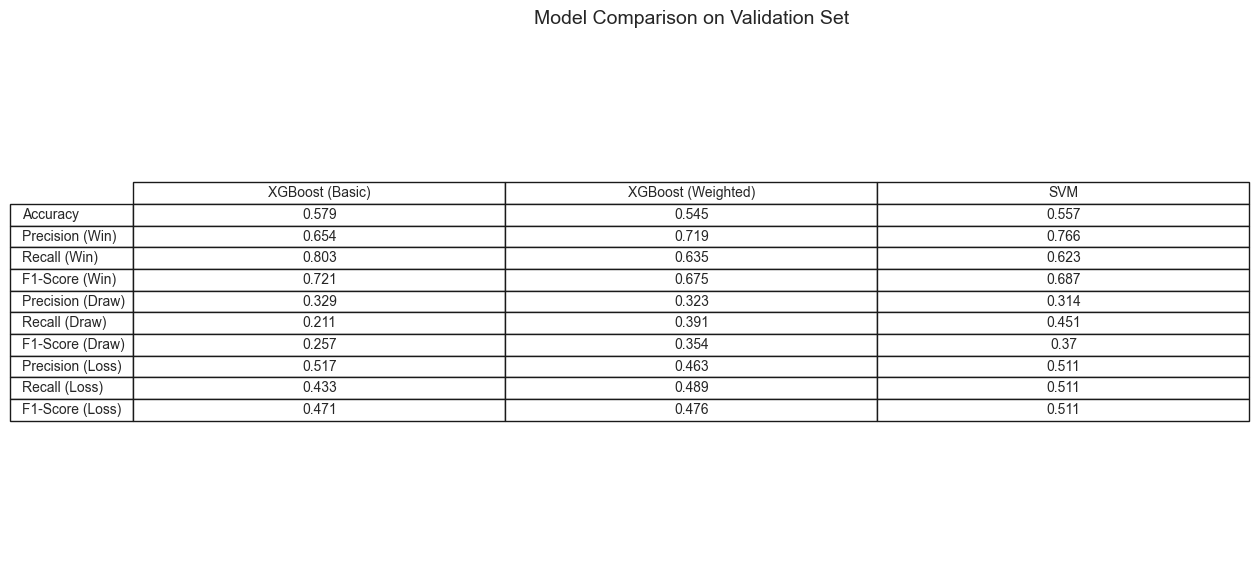

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "XGBoost (Basic)": xgb_model1,
    "XGBoost (Weighted)": xgb_model2,
    "SVM": svm_model
}
results = []
for name, model in models.items():
    if name == "SVM":
        X_val_used = X_val_scaled
    else:
        X_val_used = X_val
    accuracy = round(model.score(X_val_used, y_val), 3)
    report = classification_report(y_val, model.predict(X_val_used), target_names=le.classes_, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (Win)": round(report['Win']['precision'], 3),
        "Recall (Win)": round(report['Win']['recall'], 3),
        "F1-Score (Win)": round(report['Win']['f1-score'], 3),
        "Precision (Draw)": round(report['Draw']['precision'], 3),
        "Recall (Draw)": round(report['Draw']['recall'], 3),
        "F1-Score (Draw)": round(report['Draw']['f1-score'], 3),
        "Precision (Loss)": round(report['Loss']['precision'], 3),
        "Recall (Loss)": round(report['Loss']['recall'], 3),
        "F1-Score (Loss)": round(report['Loss']['f1-score'], 3),
    })

results_df = pd.DataFrame(results)
results_df = results_df.set_index("Model").T  # 🔄 Transpose so models become columns

# --- Plot as table ---
fig_height = 2 + len(results_df) * 0.5
fig, ax = plt.subplots(figsize=(12, fig_height))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=results_df.values,
                     rowLabels=results_df.index,
                     colLabels=results_df.columns,
                     cellLoc='center',
                     loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.3)
plt.title("Model Comparison on Validation Set", fontsize=14)
plt.show()
